In [2]:
import numpy as np
import suite2p
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Sequence, Dict, Any
from scipy.stats import kde, pearsonr
import numpy as np
import pandas as pd
import os
import pickle
from scipy.signal import find_peaks
import cottage_analysis as cott
from cottage_analysis.imaging.common import align_timestamps, find_frames

from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
import motion_model as mm
from motion_model.util import lag_tensor
import jax
import jax.numpy as jnp
import numpy as np
import haiku as hk
import graphviz
import optax


## Real Data RS & OF

In [11]:
# ----------------------------------------------------
# --------------------- filepath ---------------------
# ----------------------------------------------------
rawdata_root = '/camp/lab/znamenskiyp/data/instruments/raw_data/projects/'
root = '/camp/lab/znamenskiyp/home/shared/projects/'
project = 'hey2_3d-vision_20210716'
data_dir = ''
mouse = 'PZAH2.1b'
session = 'S20210916'
recording = 'R163430'
protocol = 'SphereSparseNoise'
suite2p_dir = 'suite2p_rois_0/suite2p/plane0/'
trace_dir = 'suite2p_traces_0/'

def generate_filefolder(root, rawdata_root, project, data_dir, mouse, session, recording, protocol):
    rawdata_folder = rawdata_root + project + '/' + data_dir + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    preprocess_folder = root + project + '/' + data_dir + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    analysis_folder = root + project + '/' + data_dir + 'Analysis/' + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    
    return rawdata_folder, preprocess_folder, analysis_folder

def generate_suite2p_folder(root, project, data_dir, mouse, session, recording, protocol, suite2p_dir, trace_dir):
    suite2p_folder = root + project + '/' + data_dir + mouse + '/' + session + '/' + suite2p_dir
    protocol_folder = root + project + '/' + data_dir + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    trace_folder = protocol_folder +  protocol + '_' + trace_dir
    
    return suite2p_folder, protocol_folder, trace_folder


rawdata_folder, preprocess_folder, analysis_folder = generate_filefolder(root, rawdata_root, project, data_dir, mouse, session, recording, protocol)

suite2p_folder, protocol_folder, trace_folder = generate_suite2p_folder(root, project, data_dir, mouse, session, recording, protocol, suite2p_dir, trace_dir)

if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

    
# ----------------------------------------------------
# --------------------- Load files ---------------------
# ----------------------------------------------------
# Load parameters
with open(protocol_folder+'img_VS.pickle', 'rb') as handle:
    img_VS = pickle.load(handle)
    
img_VS['Stim'] = np.nan
img_VS.loc[img_VS.Depth.notnull(), 'Stim'] = 1
img_VS.loc[img_VS.Depth<0, 'Stim'] = 0
img_VS.loc[((img_VS[img_VS.Depth<0]).index.values-1),'Stim'] = 0

img_VS_simple = img_VS[(img_VS['Stim'].diff()!=0) & (img_VS['Stim'].notnull())]
img_VS_simple.Depth = np.round(img_VS_simple.Depth,2)

# Find stim frames
depth_list = [0.2, 0.63, 2]
stim_dict = {}
for istim in depth_list:  
    stim_dict['stim'+str(istim)] = {}
    stim_dict['stim'+str(istim)]['start'] = img_VS_simple[(img_VS_simple['Depth']==istim) & (img_VS_simple['Stim']==1)].index.values
    stim_dict['stim'+str(istim)]['stop'] = img_VS_simple[(img_VS_simple['Depth']==istim) & (img_VS_simple['Stim']==0)].index.values
    
blank_points = img_VS_simple.index.values[1:-1]
stim_dict['blank'] = {}
stim_dict['blank']['start'] = blank_points[0::2] + 1
stim_dict['blank']['stop'] = blank_points[1::2] - 1


# ----------------------------------------------------
# --------------------- RS, OF, dFF ---------------------
# ----------------------------------------------------
# Utils
def find_min_trial_num_all_depths(stim_dict, depth_list, isStim=True):
    if isStim:
        trial_nums = []
        for idepth in range(len(depth_list)):
            depth = depth_list[idepth]
            frame_dict = stim_dict['stim'+str(depth)]
            trial_nums.append(len(frame_dict['start']))
        trial_nums = np.array(trial_nums)
        if not np.all(trial_nums==trial_nums[0]):
            print('Trials nums are not the same. Take the min trial num.')
        trial_num = np.min(trial_nums)
    else: 
        trial_num = len(stim_dict['blank']['stop'])    
    return trial_num

def find_min_frame_num_per_trial(depth_list, stim_dict, isStim=True):
    if isStim: 
        trial_num = find_min_trial_num_all_depths(stim_dict, depth_list)
        frame_num_arr = np.zeros((len(depth_list),trial_num))
        for idepth in range(len(depth_list)):
            for itrial in range(trial_num):
                frame_start = stim_dict['stim'+str(depth_list[idepth])]['start'][itrial]
                frame_stop = stim_dict['stim'+str(depth_list[idepth])]['stop'][itrial]
                frame_num = frame_stop - frame_start+1
                frame_num_arr[idepth, itrial] = frame_num
    else:
        trial_num = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=False)
        frame_num_arr = np.zeros(trial_num)
        for itrial in range(trial_num):
            frame_start = stim_dict['blank']['start'][itrial]
            frame_stop = stim_dict['blank']['stop'][itrial]
            frame_num = frame_stop - frame_start+1
            frame_num_arr[itrial] = frame_num
    return int(np.min(frame_num_arr))

# Create an array to store the traces for each roi, format: depth x trial x frames_per_trial
def create_trace_arr_per_roi(which_roi, dffs, depth_list, stim_dict, isStim=True, blank_period=0, frame_rate=30):
    trial_num = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=isStim)
    frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict, isStim=isStim)
    frame_num_pertrial = frame_num_pertrial + blank_period*frame_rate*2
    dff = dffs[which_roi,:]
    if isStim:
        trace_arr = np.zeros((len(depth_list),trial_num, frame_num_pertrial))
        for idepth in range(0,len(depth_list)):
            depth = depth_list[idepth]
            for itrial in range(0, trial_num):
                frame_start = stim_dict['stim'+str(depth)]['start'][itrial] - blank_period*frame_rate
                trace_arr[idepth, itrial,:] = dff[frame_start:(frame_start+frame_num_pertrial)]  
    else:
        trace_arr = np.zeros((1,trial_num, frame_num_pertrial))
        for itrial in range(0, trial_num):
            frame_start = stim_dict['blank']['start'][itrial]
            trace_arr[0, itrial,:] = dff[frame_start:(frame_start+frame_num_pertrial)]
    return trace_arr

# Create an array to store the speed for each trial, format: depth x trial x frames_per_trial
def create_speed_arr(speeds, depth_list, stim_dict, isStim=True, blank_period=0, frame_rate=30):
    trial_num = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=isStim)
    frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict, isStim=isStim)
    frame_num_pertrial = frame_num_pertrial + blank_period*frame_rate*2
    if isStim:
        speed_arr = np.zeros((len(depth_list),trial_num, frame_num_pertrial))
        for idepth in range(0,len(depth_list)):
            depth = depth_list[idepth]
            for itrial in range(0, trial_num):
                frame_start = stim_dict['stim'+str(depth)]['start'][itrial] - blank_period*frame_rate
                speed_arr[idepth, itrial,:] = speeds[frame_start:(frame_start+frame_num_pertrial)]
    else:
        speed_arr = np.zeros((1,trial_num, frame_num_pertrial))
        for itrial in range(0, trial_num):
            frame_start = stim_dict['blank']['start'][itrial]
            speed_arr[0, itrial,:] = speeds[frame_start:(frame_start+frame_num_pertrial)]   
    return speed_arr

def segment_arr(arr_idx, segment_size):
    batch_num = len(arr_idx)//segment_size
    segment_starts = np.arange(0,batch_num*segment_size+1,segment_size)
    segment_ends = np.arange(segment_size,batch_num*segment_size+segment_size,segment_size)
    if len(arr_idx)%segment_size!=0:
        segment_ends = np.concatenate((segment_ends, (arr_idx[-1]+1).reshape(-1)))
    segment_starts = (segment_starts+arr_idx[0])[:len(segment_ends)]
    segment_ends = segment_ends+arr_idx[0]
    return segment_starts, segment_ends 



# Speed (Unit: cm/s)
speeds = img_VS.EyeZ.diff()/img_VS.HarpTime.diff()*100
speeds[0] = 0

# Process speed: take abs, thresholding
def thr(arr, thr):
#     arr = np.abs(arr)
    arr[arr<thr] = thr
    
    return arr

rs_thr = 0.01
speeds = thr(speeds, thr=rs_thr)


# Optic flow (Unit: rad/s)
all_depths = img_VS.Depth.replace(-99.99,np.nan)
optics = speeds/(all_depths*100)
optics = np.array(optics)


# Process RS & OF data
# Lag array
frame_rate = 30
rs_lag_min = -0.5
rs_lag_max = 1
of_lag_min = 0
of_lag_max = 1
choose_trials = 50
low_value_pcent = 0.9

rs_lags = lag_tensor(speeds, nlags_min=int(frame_rate*rs_lag_min), nlags_max = int(frame_rate*rs_lag_max))
of_lags = lag_tensor(optics, nlags_min=int(frame_rate*of_lag_min), nlags_max = int(frame_rate*of_lag_max))

# For each lag column, find the rows for stim frames
(ndepths, ntrials, nframes) = create_speed_arr(speeds, depth_list, stim_dict, isStim=True).shape
rs_stim = np.zeros((rs_lags.shape[1], ndepths, ntrials, nframes))
of_stim = np.zeros((of_lags.shape[1], ndepths, ntrials, nframes))
for icol in range(rs_lags.shape[1]):
    rs_stim[icol] = create_speed_arr(rs_lags[:,icol], depth_list, stim_dict, isStim=True)
for icol in range(of_lags.shape[1]):
    of_stim[icol] = create_speed_arr(of_lags[:,icol], depth_list, stim_dict, isStim=True)
    
# replace nan with 0: HOW TO DEAL WITH NAN IN OF? 
# Thresholding OF
of_thr = 0.0001
of_stim = np.nan_to_num(of_stim)
of_stim = thr(of_stim, thr=of_thr)

# Choose trials
rs_stim = rs_stim[:,:,:choose_trials,:]
of_stim = of_stim[:,:,:choose_trials,:]
rs_stim = rs_stim.reshape(rs_stim.shape[0],-1).T
of_stim = of_stim.reshape(of_stim.shape[0],-1).T

# Take out rows with lots of low values
def discard_low_values_rows(arr, thr, low_value_pcent):
    low_value_num = int(arr.shape[1]*low_value_pcent)
    [discarded_irows] = np.array(np.where(np.array([np.sum(arr[i,:]<=thr) for i in range(arr.shape[0])]).flatten()>low_value_num))
    filtered_arr = np.delete(arr, discarded_irows, 0)
    return discarded_irows, filtered_arr

discarded_irows, rs_stim = discard_low_values_rows(rs_stim, rs_thr, low_value_pcent)
of_stim = np.delete(of_stim, discarded_irows,0)


# Log RS & OF
rs_stim_analysis = np.log(rs_stim)
of_stim_analysis = np.log(of_stim)

rs_x = rs_stim_analysis
of_x = of_stim_analysis



## Trace


In [12]:
# ----------------------------------------------------
# --------------------- Load files ---------------------
# ----------------------------------------------------

# Load suite2p extracted traces
# F = np.load(suite2p_folder+'F.npy', allow_pickle=True)
# Fneu = np.load(suite2p_folder+'Fneu.npy', allow_pickle=True)
# spks = np.load(suite2p_folder+'spks.npy', allow_pickle=True)
# stat = np.load(suite2p_folder+'stat.npy', allow_pickle=True)
# ops =  np.load(suite2p_folder+'ops.npy', allow_pickle=True)
# ops = ops.item()
iscell = np.load(suite2p_folder+'iscell.npy', allow_pickle=True)[:,0]
# output_op = ops

f_cells = np.load(Path(trace_folder).joinpath('F.npy'))
# f_neus = np.load(Path(trace_folder).joinpath('Fneu.npy'))
# spks = np.load(Path(trace_folder).joinpath('spks.npy'))
f_ast = np.load(Path(trace_folder).joinpath('Fast.npy'))


# ----------------------------------------------------
# --------------------- Process dFF ---------------------
# ----------------------------------------------------

# All_rois
which_rois = (np.arange(f_cells.shape[0]))[iscell.astype('bool')]

# dF/F
def dFF(f_cells):
    f_mean = np.average(f_cells,axis=1).reshape(-1,1)
    dffs = (f_cells-f_mean)/f_mean
    return dffs
dffs = dFF(f_cells)
dffs_ast = dFF(f_ast)



# Model fitting

In [ ]:
# Stratify data 
from random import shuffle
def stratify_index(data, batch_size, nbatches=None):
    '''Stratify data into mini batches'''
    nrows = data.shape[0]
    rows = np.arange(nrows)   
    shuffle(rows)
    stratified_idx = []
    if nbatches!=None:
        batch_size = nrows//nbatches
    else:
        nbatches = int(np.ceil(nrows/batch_size))
    for i in range(nbatches-1):
        stratified_idx.append(rows[i*batch_size:(i+1)*batch_size])
    stratified_idx.append(rows[batch_size*(nbatches-1):])
    return stratified_idx


# Training
@jax.jit
def update(params, rs, of, spikes, opt_state):
    """Apply optimizer."""
    nll, grads = jax.value_and_grad(mm.model.rs_of_integration_loss)(params, rs, of, spikes)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, nll, grads


In [ ]:
seed=42
lr=1e-2
nepoches = 10
batch_size = 1000
nsteps = 1000
save_prefix = 'plots/modelling_new/'
if not os.path.exists(analysis_folder+save_prefix):
    os.makedirs(analysis_folder+save_prefix)

rs_x = rs_x
of_x = of_x
nbatches = int(np.ceil(len(spikes)/batch_size))

# Choose ROI - Process dFF
rois_mins, rois_maxs = segment_arr(np.arange(0,len(which_rois),1), segment_size = 10)
for rois_min, rois_max in zip(rois_mins, rois_maxs):
    select_rois = which_rois[rois_min:rois_max]
    with PdfPages(analysis_folder+save_prefix+'roi'+str(rois_min)+'-'+str(rois_max)+'.pdf') as pdf:
        for choose_roi in select_rois:
            loss_history = []
            grads_history = []

            trace_arr = create_trace_arr_per_roi(choose_roi, dffs, depth_list, stim_dict, isStim=True, blank_period=0, frame_rate=30)
            # Choose trials
            trace_stim = trace_arr[:,:choose_trials,:]
            trace_stim = trace_stim.flatten().reshape(-1,1)
            # Take out rows with lots of low values
            trace_stim = np.delete(trace_stim, discarded_irows,0)
            spikes = trace_stim

            # Initialization
            rng_key = jax.random.PRNGKey(seed)
            init_params = mm.model.rs_of_integration.init(rng=rng_key, rs=rs_x, of=of_x)
            params = init_params
            opt = optax.adam(lr)
            opt_state = opt.init(params)


            for iepoch in range(nepoches):
                stratified_idx = stratify_index(spikes,batch_size=batch_size)

                for ibatch in range(nbatches):
                    spikes_mini = spikes[stratified_idx[ibatch]]
                    rs_x_mini = rs_x[stratified_idx[ibatch]]
                    of_x_mini = of_x[stratified_idx[ibatch]]


                    for step in range(nsteps):
                        params, opt_state, nll, grads = update(params, jnp.array(rs_x_mini, dtype=jnp.float32), jnp.array(of_x_mini, dtype=jnp.float32), jnp.array(spikes_mini, dtype=jnp.float32), opt_state)
            #             if step % 20 == 0:
            #                 print(f"[Step {step}] nll: {nll:.3f}")
                        loss_history.append(nll)
                    print(f'[batch {ibatch}] nll: {nll:.3f}')
                print(f'[epoch {iepoch}] nll: {nll:.3f}')


            # ---Plotting---
            # R-squared
            def calculate_R_squared(actual_data, predicted_data):
                actual_data = np.array(actual_data)
                predicted_data = np.array(predicted_data)
                explained_var = np.sum((predicted_data-np.mean(actual_data))**2)
                total_var = np.sum((actual_data - np.mean(actual_data))**2)
                R_squared = explained_var/total_var
                return R_squared

            plot_rows = 5
            plot_cols = 4
            plot_start = 0
            plot_end = 1000

            plt.figure(figsize=(7*plot_cols,5*plot_rows))
            plt.subplot2grid([plot_rows,plot_cols],[0,0])
            plt.plot(rs_stim[:,int(frame_rate*np.abs(rs_lag_min))])
            plt.title('ROI'+str(choose_roi)+' RS cm/s')

            plt.subplot2grid([plot_rows,plot_cols],[0,1])
            plt.hist(rs_stim[:,int(frame_rate*np.abs(rs_lag_min))],bins=50)
            plt.title('Hist RS')

            plt.subplot2grid([plot_rows,plot_cols],[1,0])
            plt.plot(np.log(rs_stim[:,int(frame_rate*np.abs(rs_lag_min))]))
            plt.title('log(RS) cm/s')

            plt.subplot2grid([plot_rows,plot_cols],[1,1])
            plt.hist(np.log(rs_stim[:,int(frame_rate*np.abs(rs_lag_min))]),bins=50)
            plt.title('Hist log(RS)')

            plt.subplot2grid([plot_rows,plot_cols],[0,2])
            plt.plot(of_stim[:,int(frame_rate*np.abs(of_lag_min))])
            plt.title('OF rad/s')

            plt.subplot2grid([plot_rows,plot_cols],[0,3])
            plt.hist(of_stim[:,int(frame_rate*np.abs(of_lag_min))],bins=50)
            plt.title('Hist OF')

            plt.subplot2grid([plot_rows,plot_cols],[1,2])
            plt.plot(np.log(of_stim[:,int(frame_rate*np.abs(of_lag_min))]))
            plt.title('log(OF) rad/s')

            plt.subplot2grid([plot_rows,plot_cols],[1,3])
            plt.hist(np.log(of_stim[:,int(frame_rate*np.abs(of_lag_min))]),bins=50)
            plt.title('Hist log(OF)')

            plt.subplot2grid([plot_rows,plot_cols],[2,0], colspan=2)
            loss_history = np.array(loss_history)
            plt.plot(loss_history[loss_history<10000])
            plt.xlabel('steps')
            plt.ylabel('loss')
            plt.title('Loss')

            plt.subplot2grid([plot_rows,plot_cols],[2,2], colspan=2)
            plt.plot(spikes, label='Data')
            plt.plot(mm.model.rs_of_integration.apply(params=params, rs=rs_x, of=of_x), label='Model fit')
            R_squared = calculate_R_squared(actual_data=spikes, predicted_data=mm.model.rs_of_integration.apply(params=params, rs=rs_x, of=of_x))
            plt.title('Data vs model fit, loss: ' +str(np.around(loss_history[-1]))+' R2: '+str(R_squared))

            plt.subplot2grid([plot_rows,plot_cols],[3,0], colspan=2)
            x_axis = np.arange(-20,20,0.001)
            plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, params['gaussian_module']['mu'], np.exp(params['gaussian_module']['log_sigma'])),label='Trained')
            plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, init_params['gaussian_module']['mu'], np.exp(params['gaussian_module']['log_sigma'])),label='Init')
            plt.title('Gaussian kernel for RS, mu='+str(np.round(np.array(params['gaussian_module']['mu']),2))+' log_sigma='+str(np.round(np.array(params['gaussian_module']['log_sigma']),2)))
            plt.legend()

            plt.subplot2grid([plot_rows,plot_cols],[3,2], colspan=2)
            plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, params['gaussian_module_1']['mu'], np.exp(params['gaussian_module_1']['log_sigma'])),label='Trained')
            plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, init_params['gaussian_module_1']['mu'], np.exp(params['gaussian_module_1']['log_sigma'])),label='Init')
            plt.title('Gaussian kernel for OF, mu='+str(np.round(np.array(params['gaussian_module_1']['mu']),2))+' log_sigma='+str(np.round(np.array(params['gaussian_module_1']['log_sigma']),2)))
            plt.legend()

            plt.subplot2grid([plot_rows,plot_cols],[4,0], colspan=2)
            plt.plot(np.linspace(rs_lag_min,rs_lag_max,int(frame_rate*(rs_lag_max-rs_lag_min))),params['linear']['w'], label='Trained')
            plt.plot(np.linspace(-0.5,1,int(frame_rate*(1-(-0.5)))),init_params['linear']['w'], label='Init')
            plt.xlabel('lags')
            plt.ylabel('w')
            plt.title('Linear kernel for RS')
            plt.legend()

            plt.subplot2grid([plot_rows,plot_cols],[4,2], colspan=2)
            plt.plot(np.linspace(of_lag_min,of_lag_max,int(frame_rate*(of_lag_max-of_lag_min))),params['linear_1']['w'], label='Trained')
            plt.plot(np.linspace(of_lag_min,of_lag_max,int(frame_rate*(of_lag_max-of_lag_min))),init_params['linear_1']['w'], label='Init')
            plt.xlabel('lags')
            plt.ylabel('w')
            plt.title('Linear kernel for OF')
            plt.legend()

            plt.tight_layout(pad=1)
            pdf.savefig()
            plt.close()




[batch 0] nll: 275.664
[batch 1] nll: 225.302
[batch 2] nll: 244.120
[batch 3] nll: 209.952
[batch 4] nll: 165.561
[batch 5] nll: 185.566
[batch 6] nll: 266.906
[batch 7] nll: 209.500
[batch 8] nll: 164.063
[batch 9] nll: 184.665
[batch 10] nll: 174.251
[batch 11] nll: 134.162
[batch 12] nll: 275.418
[batch 13] nll: 219.809
[batch 14] nll: 202.174
[batch 15] nll: 189.707
[batch 16] nll: 202.744
[batch 17] nll: 334.785
[batch 18] nll: 216.581
[batch 19] nll: 256.301
[batch 20] nll: 204.836
[batch 21] nll: 323.335
[batch 22] nll: 212.388
[batch 23] nll: 246.286
[batch 24] nll: 236.351
[batch 25] nll: 240.612
[batch 26] nll: 195.182
[batch 27] nll: 231.915
[batch 28] nll: 171.436
[batch 29] nll: 215.706
[batch 30] nll: 185.180
[batch 31] nll: 135.911
[batch 32] nll: 286.712
[batch 33] nll: 163.589
[batch 34] nll: 181.731
[batch 35] nll: 203.332
[batch 36] nll: 169.759
[batch 37] nll: 127.150
[batch 38] nll: 295.764
[batch 39] nll: 257.280
[batch 40] nll: 249.459
[batch 41] nll: 291.400
[b

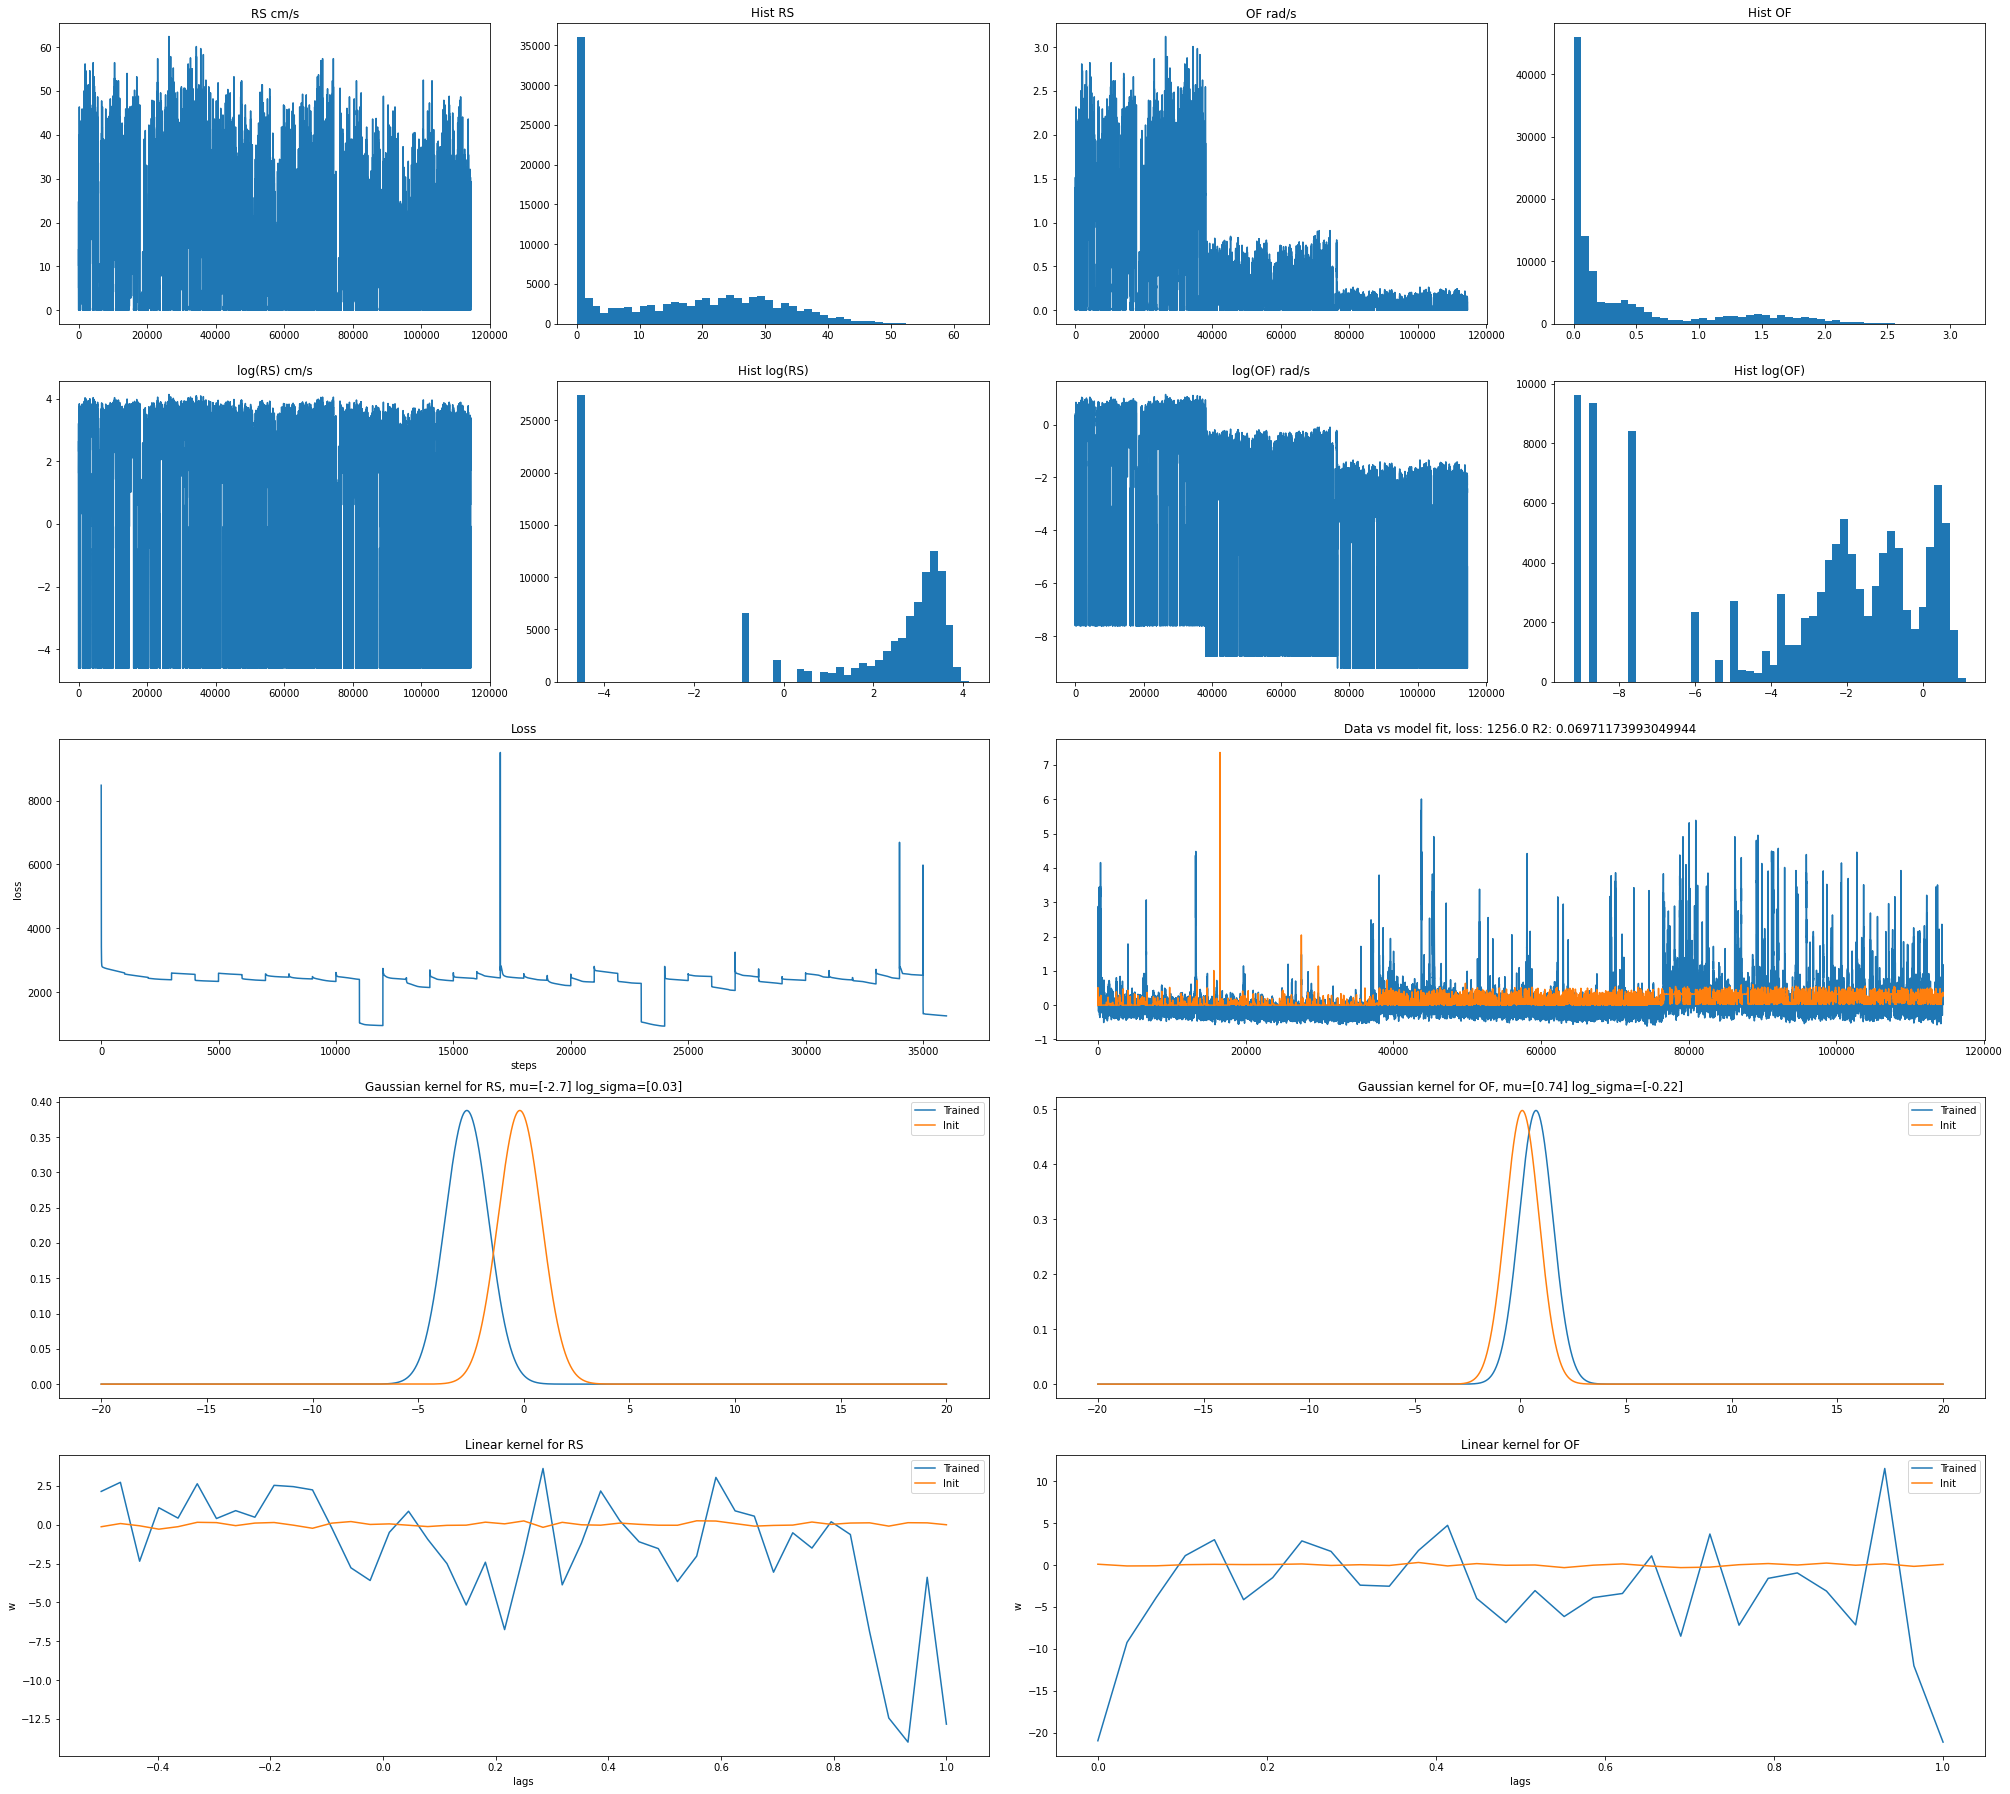

In [31]:
# R-squared
def calculate_R_squared(actual_data, predicted_data):
    actual_data = np.array(actual_data)
    predicted_data = np.array(predicted_data)
    explained_var = np.sum((predicted_data-np.mean(actual_data))**2)
    total_var = np.sum((actual_data - np.mean(actual_data))**2)
    R_squared = explained_var/total_var
    return R_squared

plot_rows = 5
plot_cols = 4
plot_start = 0
plot_end = 1000

plt.figure(figsize=(7*plot_cols,5*plot_rows))
plt.subplot2grid([plot_rows,plot_cols],[0,0])
plt.plot(rs_stim[:,int(frame_rate*np.abs(rs_lag_min))])
plt.title('RS cm/s')

plt.subplot2grid([plot_rows,plot_cols],[0,1])
plt.hist(rs_stim[:,int(frame_rate*np.abs(rs_lag_min))],bins=50)
plt.title('Hist RS')

plt.subplot2grid([plot_rows,plot_cols],[1,0])
plt.plot(np.log(rs_stim[:,int(frame_rate*np.abs(rs_lag_min))]))
plt.title('log(RS) cm/s')

plt.subplot2grid([plot_rows,plot_cols],[1,1])
plt.hist(np.log(rs_stim[:,int(frame_rate*np.abs(rs_lag_min))]),bins=50)
plt.title('Hist log(RS)')

plt.subplot2grid([plot_rows,plot_cols],[0,2])
plt.plot(of_stim[:,int(frame_rate*np.abs(of_lag_min))])
plt.title('OF rad/s')

plt.subplot2grid([plot_rows,plot_cols],[0,3])
plt.hist(of_stim[:,int(frame_rate*np.abs(of_lag_min))],bins=50)
plt.title('Hist OF')

plt.subplot2grid([plot_rows,plot_cols],[1,2])
plt.plot(np.log(of_stim[:,int(frame_rate*np.abs(of_lag_min))]))
plt.title('log(OF) rad/s')

plt.subplot2grid([plot_rows,plot_cols],[1,3])
plt.hist(np.log(of_stim[:,int(frame_rate*np.abs(of_lag_min))]),bins=50)
plt.title('Hist log(OF)')

plt.subplot2grid([plot_rows,plot_cols],[2,0], colspan=2)
loss_history = np.array(loss_history)
plt.plot(loss_history[loss_history<10000])
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot2grid([plot_rows,plot_cols],[2,2], colspan=2)
plt.plot(spikes, label='Data')
plt.plot(mm.model.rs_of_integration.apply(params=params, rs=rs_x, of=of_x), label='Model fit')
R_squared = calculate_R_squared(actual_data=spikes, predicted_data=mm.model.rs_of_integration.apply(params=params, rs=rs_x, of=of_x))
plt.title('Data vs model fit, loss: ' +str(np.around(loss_history[-1]))+' R2: '+str(R_squared))

plt.subplot2grid([plot_rows,plot_cols],[3,0], colspan=2)
x_axis = np.arange(-20,20,0.001)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, params['gaussian_module']['mu'], np.exp(params['gaussian_module']['log_sigma'])),label='Trained')
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, init_params['gaussian_module']['mu'], np.exp(params['gaussian_module']['log_sigma'])),label='Init')
plt.title('Gaussian kernel for RS, mu='+str(np.round(np.array(params['gaussian_module']['mu']),2))+' log_sigma='+str(np.round(np.array(params['gaussian_module']['log_sigma']),2)))
plt.legend()

plt.subplot2grid([plot_rows,plot_cols],[3,2], colspan=2)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, params['gaussian_module_1']['mu'], np.exp(params['gaussian_module_1']['log_sigma'])),label='Trained')
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, init_params['gaussian_module_1']['mu'], np.exp(params['gaussian_module_1']['log_sigma'])),label='Init')
plt.title('Gaussian kernel for OF, mu='+str(np.round(np.array(params['gaussian_module_1']['mu']),2))+' log_sigma='+str(np.round(np.array(params['gaussian_module_1']['log_sigma']),2)))
plt.legend()

plt.subplot2grid([plot_rows,plot_cols],[4,0], colspan=2)
plt.plot(np.linspace(rs_lag_min,rs_lag_max,int(frame_rate*(rs_lag_max-rs_lag_min))),params['linear']['w'], label='Trained')
plt.plot(np.linspace(-0.5,1,int(frame_rate*(1-(-0.5)))),init_params['linear']['w'], label='Init')
plt.xlabel('lags')
plt.ylabel('w')
plt.title('Linear kernel for RS')
plt.legend()

plt.subplot2grid([plot_rows,plot_cols],[4,2], colspan=2)
plt.plot(np.linspace(of_lag_min,of_lag_max,int(frame_rate*(of_lag_max-of_lag_min))),params['linear_1']['w'], label='Trained')
plt.plot(np.linspace(of_lag_min,of_lag_max,int(frame_rate*(of_lag_max-of_lag_min))),init_params['linear_1']['w'], label='Init')
plt.xlabel('lags')
plt.ylabel('w')
plt.title('Linear kernel for OF')
plt.legend()

plt.tight_layout(pad=1)


In [281]:
import pickle
with open('params_sim.pickle', 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('params_sim.pickle', 'rb') as handle:
    b = pickle.load(handle)
    